+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

RUNNING JUPYTER on SANGO (node: compute)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

srun --time=2:00:00 --cpus-per-task=10 --partition=compute --mem=10G --ntasks=1 --pty bash
conda activate NEST

THE PROMPT SHOULD LOOK LIKE THAT:
(NEST) [roman-koshkin@sango10915 HMAX]$ 

ENTER THIS (NOTE THE PREFIX OF OIST (THAT'S THE NODENAME YOU'VE BEEN ALLOCATED))

jupyter notebook --NotebookApp.port=8888 --NotebookApp.ip=sango10915.oist.jp

COPY THIS URL INTO YOUR LOCAL BROWSER:

http://sango10915.oist.jp:8888/?token=aebbdb88fb411026b1c84279a2aa58cda108dacf440b424b

ENJOY

# TODO

### Only the winner's weights are updated (across all the scales

In [1]:
import random as rnd
import tarfile
import nest
import pickle
import itertools
import subprocess
import os

import numpy as np

import matplotlib
matplotlib.use('pdf')

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.pylab import *

from scipy import signal
import scipy.stats as ss
from scipy.stats import norm
from scipy.special import softmax
from scipy.ndimage.filters import gaussian_filter1d as gauss

from scipy.signal import argrelextrema, butter, filtfilt
from scipy.signal import convolve2d as conv2d
from scipy import signal

import skimage
from skimage.measure import block_reduce as MaxPooling2D
from skimage.transform import resize as imresize
from skimage.color import rgb2gray
from skimage.util.shape import view_as_windows

from sklearn.metrics import auc
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.datasets import fetch_openml

from utils.printProgressBar import printProgressBar
from mpl_toolkits.axes_grid1 import host_subplot
from utils.AddFig2Movie import AddFig2Movie
import copy
import time

if not 'mnist' in locals():
    mnist = fetch_openml('mnist_784', version=1, cache=True)



def gabor(sigma=1, theta=0, Lambda=1, psi=0, gamma=1):
    """
    Gabor feature extraction.
    sigma - length of a standard deviation (pixels)
    lambda - wavelength
    psi - phase shift
    gamma - ellipticity
    
    Usage:
    gabor(sigma=5, theta=np.pi/4, Lambda=6, psi=0, gamma=1)
    will give you a round (not elliptical) gabor filter of size (5,5) and a wavelength of 6
    """
    sigma_x = sigma
    sigma_y = float(sigma) / gamma

    # Bounding box
    nstds = 1  # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

def get_scaled(im, imsize, pad=False):
    IM = []
    im = rgb2gray(im)
    im = imresize(im, imsize)
    org_s = im.shape[0]
    percentages = [1, 0.75, 0.5, 0.35, 0.25]
    for p in percentages:
        s = int(np.sqrt(im.flatten().shape[0]*p)) # сторона квадрата
        im_ = imresize(im, (s, s))
        if pad:
            pad_with = int(np.floor((org_s-s)/2)) + 1
            im_ = np.pad(im_, pad_width=pad_with, mode='constant', constant_values=0)
            print(im_.shape)
            im_ = im_[:imsize[0], :imsize[1]]
        IM.append(im_)
    return IM

def get_filters(THETAS):
    sigma = 2
    Lambda = 5
    gamma = 1
    G = []
    for theta in THETAS:
        G.append(gabor(sigma=sigma, theta=theta, Lambda=Lambda, psi=0, gamma=gamma))
#         plt.subplot(1,4, i+1)
#         plt.imshow(G[-1])
    return G

def get_S1_maps(scaled_IM, kernels, input_size):
    S1maps = {}
    for im in range(len(scaled_IM)): # loop over the scaled versions of the image
        S1maps['scale'+str(im)] = np.zeros((4,) + scaled_IM[im].shape)
        for k in range(len(kernels)):# loop over the filters
            S1map = minmax_scale(conv2d(scaled_IM[im], kernels[k], mode='same').flatten(), (0, 255-0.01)).reshape(scaled_IM[im].shape)
            S1maps['scale'+str(im)][k,:,:] = S1map
    return S1maps

def get_C1_maps(S1maps):
    C1maps = {}
    for scale in S1maps.keys():
        C1maps[scale] = []    # init empty list for one processing scale
        for orientation in range(S1maps[scale].shape[0]):
            # break into receptive fields (windows of size 7 with stride 6)
            X = view_as_windows(S1maps[scale][orientation,:,:], window_shape = (7,7), step=(6,6))
            C1map = np.zeros((X.shape[0], X.shape[1]))
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    X_r = ss.rankdata(X[i,j,:,:].flatten(), method='ordinal').reshape(7,7)
                    C1map[i,j] = X[(i,j) + np.where(X_r==X_r.max())]
            C1maps[scale].append(C1map) # append to the current processing scale another orientation map
        C1maps[scale] = np.stack(C1maps[scale], axis=0)
    return C1maps

def inv_gauss_mask(size, fwhm=3, center=None):
    """ Make a square gaussian kernel. 
    size is the length of a side of the square 
    fwhm is full-width-half-maximum, which can be thought of as an effective radius."""
    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    g = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2) + 1
    g[x0, y0] = 1
    return g

def encode_C1maps(C1maps, snap=2): 
    """ covert pixel intensities to lantecies """
    C1maps_ = copy.deepcopy(C1maps)
    for k in C1maps_.keys():
        for j in range(C1maps_[k].shape[0]):
            C1maps_[k][j] = np.abs(np.round(255 - C1maps_[k][j], snap)) # snap to 0.01 ms steps
    return C1maps_

def inhibit_laterals(input_im, out, span=5, min_att=1.05, max_att=1.15, t=-1):
    X = np.copy(input_im)
    if t >= 0:
        I, J = np.where(X==t)
        if I.size == 0:
            I, J = np.where(X==np.min(X))
            return X, I[0], J[0], np.min(X[X>t])
    if t==-1:
        I, J = np.where(X==np.amin(X))
    factor = np.linspace(min_att, max_att, span).tolist() + [1.0] + np.linspace(max_att, min_att, span).tolist()
    
    g = inv_gauss_mask(11, fwhm = 6, center=None)

    for c0,i in enumerate(np.arange(I[0]-span, I[0]+span+1)):
        for c1,j in enumerate(np.arange(J[0]-span, J[0]+span+1)):
            if i>=0 and i<X.shape[0] and j>=0 and j<X.shape[1]:
                f = g[c0,c1]
                if X[i,j] >= t:
                    X[i,j] = np.round(X[i,j]*f, 2)
            else:
                continue
    next_spike_t = np.min(X[X>t])
    return X, J[0], I[0], next_spike_t


def get_fully_inhibited_C1(C1maps_encoded):
    """Takes encoded C1 map. Runs lateral inhibition on a C1 map. The spikes that get inhibited
       beyond 250 are simply removed"""
    printProgressBar(0, 20, prefix='Progress:', suffix='Complete', length=50)
    C1maps_ = copy.deepcopy(C1maps_encoded)
    c = 0
    for scale in C1maps.keys():
        for filt in range(4):
            X_ = np.copy(C1maps_[scale][filt])      
            out = []
            t = 0.0
            next_spike_t = 0.0
            while next_spike_t < 255:
                X_, i, j, next_spike_t = inhibit_laterals(X_, out, span=5, min_att=1.05, max_att=1.55, t=t)
                t = np.round(t+0.01, 2)
                out.append((X_, i, j, next_spike_t, t))
            C1maps_[scale][filt] = X_
            c += 1
            printProgressBar(c, 20, prefix='Progress:', suffix='Sc: {}, Filt: {}, max: {:.2f}'.format(scale, filt, np.max(C1maps_[scale][filt])), length=50)
    return C1maps_

def new_simulate(T, dt, neuron_type, n, n_spike_generators, weights, in_spike_train):
    """implements online STDP. I don't exactly know now it works, but it does something"""
    nest.ResetKernel()
    nest.SetKernelStatus({"resolution": dt})
    
    iaf_neuron_parms = {
     'C_m': 1000.0, # pF
     'E_L': -65.0, # resting potential
     'I_e': 1000.0,
     't_ref': 5.0,
     'tau_m': 10.0,
     'tau_syn_ex': 1.0,
     'tau_syn_in': 2.0,
     'V_m': -60.0, # initial potential?
     'V_reset': -65.0,
     'V_th': -55.0}
    
    neurons = nest.Create(neuron_type, n)   
    spikedetectors = nest.Create('spike_detector', n)
    spikegenerators = nest.Create('spike_generator', n_spike_generators)
    voltmeters = nest.Create('voltmeter', n, params={"interval": dt})
    multimeter = nest.Create('multimeter', 1,  params = {
        'withtime':True,
        'interval':dt,
        'record_from':['V_m', 'I_syn_ex', 'I_syn_in']})
    pre_pop = nest.Create('parrot_neuron', n_spike_generators)
    
    nest.Connect(spikegenerators, pre_pop, "one_to_one")
    nest.Connect(pre_pop, neurons,
                 conn_spec='all_to_all',
                 syn_spec={'model': 'static_synapse',
                           'weight': weights,
                           'delay': 0.01}
                )
    nest.Connect(multimeter, neurons, 'one_to_one')
    nest.Connect(voltmeters, neurons, 'one_to_one')
    nest.Connect(neurons, spikedetectors, 'one_to_one')
    
    if neuron_type=='iaf_psc_alpha':
        nest.SetStatus(neurons, params=iaf_neuron_parms)
    c = 0

    
    for i in spikegenerators:
        nest.SetStatus([i], {'spike_times': np.array(in_spike_train[c]).flatten()})
        c += 1
#     nest.SetStatus([neurons[0]], {'I_e':0.0})

    nest.Simulate(T+dt)
    weights_ = np.array(nest.GetStatus(nest.GetConnections(pre_pop, neurons), keys='weight')).reshape(1,-1)
    times = nest.GetStatus(voltmeters)[0]['events']['times']
    return times, voltmeters, spikedetectors, multimeter, spikegenerators, neurons, pre_pop, weights_

# def init_weights():
#     W = {}
#     for scale in C1maps_inh.keys():
#         W[scale] = np.random.rand((*C1maps_inh[scale].shape))*1
# #         W[scale] = np.ones_like(C1maps_inh[scale]) * 450
#     return W

# def get_winning_scale(out_ST):
#     ealiest_spikes_in_scales = [np.min(i) for i in out_ST.values()]
#     winning_scale_id = np.argmin(ealiest_spikes_in_scales)
#     winning_scale_name = list(out_ST.keys())[winning_scale_id] # where the earliest spike is
#     winner_spike = np.round(np.min(out_ST[winning_scale_name]), 2)
#     return winning_scale_name, winner_spike

# def get_S2(W=[], C1maps_inh=[], T=250.0, dt=0.01, neuron_type='iaf_psc_alpha', n=1):
# #     t = time.time()
#     voltage, out_ST = {}, {}
#     for scale in C1maps_inh.keys():
#         weights = W[scale].reshape(1,-1)
#         in_spike_train = np.sort(C1maps_inh[scale].flatten())
#         n_spike_generators = in_spike_train.shape[0]
#         (times, 
#          voltmeters,
#          spikedetectors,
#          multimeter,
#          spikegenerators,
#          neurons,
#          pre_pop,
#          weights) = new_simulate(T,
#                                  dt,
#                                  neuron_type,
#                                  n,
#                                  n_spike_generators,
#                                  weights,
#                                  in_spike_train)
#         voltage[scale] = nest.GetStatus(voltmeters)[0]['events']['V_m']
#         ST_trunc = times[np.isin(times, in_spike_train)]
#         out_ST[scale] = nest.GetStatus(spikedetectors)[0]['events']['times']
# #     t = time.time() - t
# #     print('S2 maps obtained in {:.2f}'.format(t))
#     return out_ST, voltage

def STDP(W, out_ST, C1maps_inh):
    ws_t = get_winning_scale(out_ST)[1] # latency of the earliest spike
    DW = {}
    for scale in C1maps_inh.keys():
        t_j = C1maps_inh[scale] # presynaptic spike times
        t_i = out_ST[scale]
        diff = t_j - ws_t # get who late or early the presynaptic spikes are relative to the winner postsynaptic spike
        a = np.zeros_like(diff) # make a vector of learning rates 
        a_plus = 0.01
        a_minus = -0.75 * a_plus
        a[diff<=0] = a_plus # (posive for those presyn spikes that preceed (i.e. cause) the winner)
        a[diff>0] = a_minus # (negative for those presyn spikes that trail (i.e. not cause) the winner)
        dw = a * W[scale] * (1-W[scale])
        W[scale] += dw
        DW[scale] = np.copy(dw)
    return W, DW

def get_random_C1_inh(path):
    files_ = os.listdir(path)
    files = []
    for file in files_:
        files.append(path + file)
#     files.remove(path + '.DS_Store')
    with open(files[np.random.choice(len(files))], 'rb') as f: # we open a random file (each having 100 images)
        C1big = pickle.load(f)
    return C1big[np.random.choice(len(C1big))]                 # return a random image from that 100-batch

def init_weights___(C1maps_inh, n, normalize=True):
    W = {}
    for scale in C1maps_inh.keys():
        W_ = []
        for N in range(n):
            wt = np.random.rand((*C1maps_inh[scale].shape))*1
            if normalize == True:
                wt = wt/np.linalg.norm(wt)
            W_.append(wt)
        W[scale] = W_
    return W

def get_S2___(W=[], C1maps_inh=[], T=250.0, dt=0.01, neuron_type='iaf_psc_alpha', n=2):
    voltage, S2, in_spike_train, n_spike_generators, ST_trunc = {}, {}, {}, {}, {}
    for scale in C1maps_inh.keys():
        in_spike_train[scale] = np.sort(C1maps_inh[scale].flatten())
        zeros_latencies_to_be_fixed = [in_spike_train[scale] == 0.0]
        in_spike_train[scale][zeros_latencies_to_be_fixed] = 0.01
        n_spike_generators[scale] = in_spike_train[scale].shape[0]
    
    (times, 
     voltmeters,
     spikedetectors,
     spikegenerators,
     neurons) = new_simulate___(T,
                                dt,
                                neuron_type,
                                n,
                                n_spike_generators,
                                W,
                                in_spike_train)
    
    for scale in voltmeters.keys():
        voltage[scale] = [nest.GetStatus(voltmeters[scale][N])[0]['events']['V_m'] for N in range(n)]
        ST_trunc[scale] = [times[np.isin(times, in_spike_train[scale][N])] for N in range(n)]
        S2[scale] = [nest.GetStatus(spikedetectors[scale][N])[0]['events']['times'] for N in range(n)]
    return S2, voltage, times


def new_simulate___(T, dt, neuron_type, n, n_spike_generators, W, in_spike_train):
    nest.ResetKernel()
    nest.SetKernelStatus({"resolution": dt})
    
    iaf_neuron_parms = {
     'C_m': 1000.0, # pF
     'E_L': -65.0, # resting potential
     'I_e': 1000.0,
     't_ref': 5.0,
     'tau_m': 10.0,
     'tau_syn_ex': 1.0,
     'tau_syn_in': 2.0,
     'V_m': -60.0, # initial potential?
     'V_reset': -65.0,
     'V_th': -55.0}

    neurons, spikedetectors, voltmeters, spikegenerators = {}, {}, {}, {}
    for scale in W.keys():
        neurons[scale] = [nest.Create(neuron_type, 1) for N in range(n)]
        spikedetectors[scale] = [nest.Create('spike_detector', 1) for N in range(n)]
        voltmeters[scale] = [nest.Create('voltmeter', 1, params={"interval": dt}) for N in range(n)]
        spikegenerators[scale] = nest.Create('spike_generator', n_spike_generators[scale]) # each neuron in the scale will receive corresponding C1map_inh maps
    
    for scale in W.keys():
        for N in range(n):
            nest.Connect(spikegenerators[scale],
                         neurons[scale][N],
                         conn_spec='all_to_all',
                         syn_spec={'model': 'static_synapse',
                                   'weight': W[scale][N].reshape(1,-1),
                                   'delay': 0.01})
            nest.Connect(voltmeters[scale][N], neurons[scale][N], 'one_to_one')
            nest.Connect(neurons[scale][N], spikedetectors[scale][N], 'one_to_one')
            if neuron_type=='iaf_psc_alpha':
                nest.SetStatus(neurons[scale][N], params=iaf_neuron_parms)

    
    for scale in W.keys():
        c = 0
        for i in spikegenerators[scale]:
            nest.SetStatus([i], {'spike_times': np.array(in_spike_train[scale][c]).flatten()})
            c += 1

    nest.Simulate(T + dt)

    times = nest.GetStatus(voltmeters['scale0'][0])[0]['events']['times']
    
    return times, voltmeters, spikedetectors, spikegenerators, neurons

# def STDP___(W, S2, C1maps_inh):
#     ws_t = get_winning_scale___(S2) # latency of the earliest spike
#     DW = {}
#     for scale in C1maps_inh.keys():
#         dw_ = []
#         for N in range(n):
#             t_j = C1maps_inh[scale] # presynaptic spike times
#             t_i = S2[scale]
#             diff = t_j - ws_t # get who late or early the presynaptic spikes are relative to the winner postsynaptic spike
#             a = np.zeros_like(diff) # make a vector of learning rates 
#             a_plus = 0.01
#             a_minus = -0.75 * a_plus
#             a[diff<=0] = a_plus # (posive for those presyn spikes that preceed (i.e. cause) the winner)
#             a[diff>0] = a_minus # (negative for those presyn spikes that trail (i.e. not cause) the winner)
#             dw = a * W[scale][N] * (1-W[scale][N])
#             W[scale][N] += dw
#             dw_.append(np.copy(dw))
#         DW[scale] = dw_
#     return W, DW

# def get_winning_scale___(S2):
#     out = []
#     for i in itertools.chain.from_iterable(S2.values()):
#         out = out + i.tolist()
#     return np.min(out)

def STDP___(W, S2, C1maps_inh, n):
    
    """ WE ONLY UPDATE THE WEIGHTS OF THE WINNING SCALE """
    
    ws_t, winning_scale, winning_neuron = get_winning_scale___(S2) # latency of the earliest spike
    
    if ws_t == 'no_winner':
        DW = copy.deepcopy(W)
        for scale in DW.keys():
            for neuron in range(len(DW[scale])):
                DW[scale][neuron] = np.zeros_like(DW[scale][neuron])
        return W, DW
    
    DW = {}
    for scale in C1maps_inh.keys():
        dw_ = []
        for N in range(n):
#             W[scale][N] = W[scale][N]/np.linalg.norm(W[scale][N])*20
            if N==winning_neuron:
                t_j = C1maps_inh[scale] # presynaptic spike times
                t_i = S2[scale][winning_neuron] # postsynaptic spike times
                diff = t_j - ws_t # get who late or early the presynaptic spikes are relative to the winner postsynaptic spike
                a = np.zeros_like(diff) # make a vector of learning rates 
                a_plus = 0.01
                a_minus = -0.75 * a_plus
                a[diff<=0] = a_plus # (posive for those presyn spikes that preceed (i.e. cause) the winner)
                a[diff>0] = a_minus # (negative for those presyn spikes that trail (i.e. not cause) the winner)
                dw = a * W[scale][winning_neuron] * (1-W[scale][winning_neuron])
                W[scale][winning_neuron] += dw
                
                W[scale][winning_neuron] = W[scale][winning_neuron]/np.linalg.norm(W[scale][winning_neuron])
                
                dw_.append(np.copy(dw))
            else:
                dw_.append(np.zeros_like(W[scale][N]))
        DW[scale] = dw_
    return W, DW, winning_neuron, winning_scale

def get_winning_scale___(S2):
    A = []
    for scale in S2.keys():
        for neuron in range(len(S2['scale0'])):
            if len(S2[scale][neuron]) == 0:
                print('neuron {} at {} not spiking'.format(neuron, scale))
                continue
            else:
                for spike in S2[scale][neuron]:
                    A.append((spike, scale, neuron))
    if len(A)==0:
        return 'no_winner', 'no_winner', 'no_winner' 
    else:
        return sorted(A, key=lambda tup: tup[0])[0]

def snapshot(neuron_id, W, DW, frame, snapshot_num):
    fig = plt.figure(figsize=(5,8))
    c = 0
    nrows = len(C1maps_inh.keys())
    for scale in C1maps_inh.keys():
        for orientation in range(4):
            c += 1
            plt.subplot(nrows*2,4,c)
            plt.imshow(W[scale][neuron_id][orientation,:,:])
            plt.gca().set_yticklabels([])
            plt.gca().set_xticklabels([])
            plt.gca().set_axis_off()
            plt.subplot(nrows*2,4,c+nrows*4)
            plt.imshow(DW[scale][neuron_id][orientation,:,:])
            plt.gca().set_yticklabels([])
            plt.gca().set_xticklabels([])
            plt.gca().set_axis_off()
            plt.suptitle('frame: {} snapshot: {} neuron: {}'.format(frame, snapshot_num, neuron_id), weight='bold', size=18, c='yellow')
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, wspace=0.1, hspace=0.1)
    plt.savefig('frame_{:05d}_snapshot_{:05d}_neuronid_{}.png'.format(frame, snapshot_num, neuron_id), dpi=100, transparent=False, pad_inches=0.1, format='png')
    plt.close(fig)

def saveNcleanup(n, opt='arc'):
    
    if opt=='arc':
        with tarfile.open("snapshot.tar.gz", "w:gz") as tar:
            for name in [fn for fn in os.listdir() if fn.startswith(('frame_', 'backproj_'))]:
                tar.add(name)
    if opt=='vid':
        bashCommand = "ffmpeg -pattern_type glob  -f image2 -r 1/1 -i *_neuronid_{}.png -vcodec mpeg4 output_{}.mp4".format(N, N)
        process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
        output, error = process.communicate()
    
    files = os.listdir()
    for i in files:
        if 'frame_' in i or 'backproj_' in i:
            os.remove(i)
            
def plot_backprojection(W, G, n, frame, snapshot_num):
    ncols = len(W.keys())
    fig = plt.figure(figsize=(ncols*4,n*4))
    c = 0
    for neuron in range(n):
        for scale in W.keys():
            out = 0
            for orientation in range(4):
                out += conv2d(W[scale][neuron][orientation,:,:],  G[orientation], mode='same')
            plt.subplot(n, ncols, c+1)
            plt.title('Neuron: {}'.format(neuron), weight='bold')
            plt.imshow(out)
            plt.gca().set_yticklabels([])
            plt.gca().set_xticklabels([])
            plt.gca().set_axis_off()
            plt.title('neuron: {}, {}'.format(neuron, scale))
            c += 1
    fig.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, wspace=0.5, hspace=0.5)
    plt.tight_layout()
    plt.savefig('backproj_{:05d}_snapshot_{:05d}.png'.format(frame, snapshot_num), dpi=100, transparent=False, pad_inches=0.1, format='png')
    plt.close(fig)
    
# def getDS_100(path, num_scales):
#     """ Create a dataset of 100 samples """
#     files_ = os.listdir(path)
#     files = []
#     for file in files_:
#         files.append(path + file)
#     DS = []
#     for f in files:
#         with open(f, 'rb') as f:
#             xx = pickle.load(f)[0]
#             xx0 = dict((k, xx[0][k]) for k in list(xx[0].keys())[:num_scales]) # get only the first num_scales number of scales
#             DS.append((xx0, xx[1])
#     addr = [(idx, targets[1]) for idx, targets in enumerate(DS)]
#     return DS, addr
                      
def getDS_100(path, num_scales):
    """ Create a dataset of 100 samples
        NUM_SCALES specifies how many scales you need (max = 5)"""
    files_ = os.listdir(path)
    files = []
    for file in files_:
        files.append(path + file)
    DS = []
    for f in files:
        with open(f, 'rb') as f:
            xx = pickle.load(f)[0]
            xx0 = dict((k, xx[0][k]) for k in list(xx[0].keys())[:num_scales]) # get only the first num_scales number of scales
            DS.append((xx0, xx[1]))
    addr = [(idx, targets[1]) for idx, targets in enumerate(DS)]
    return DS, addr

def get1of100(DS, needed_target, addr):
    """ Draw a number from the dataset of 100 samples """
    """ returns a 3-tuple (im_dict[scales], str(figure), (addr in DS, str(figure))) """
    pointer = rnd.choice([elem for elem in addr if elem[1]==str(needed_target)])
    return DS[pointer[0]][0], DS[pointer[0]][1], pointer
    

In [10]:
""" NEW implementation. It forwards all the neurons in one pass """

input_size = (128, 128)
T = 250.0 # ms
dt = 0.01 # ms
# neuron_type = 'hh_psc_alpha'
num_scales = 2 
neuron_type = 'iaf_psc_alpha'
n = 10                                      # number of SNN outputs per scale
nframes = 3000
snapshot_every = 10
path = os.getcwd() + '/dump/'
N = 0                                       # focus on only one neuron at each scale 


THETAS = [np.pi/8, np.pi/4 + np.pi/8, np.pi/2 + np.pi/8, 3*np.pi/4 + np.pi/8]


G = get_filters(THETAS)           # get the FOUR spatial filters

DS, addr = getDS_100(path, num_scales)
C1maps_inh, fig_im, pointer = get1of100(DS, 0, addr)
# C1maps_inh, fig_im = get_random_C1_inh(path)

W = init_weights___(C1maps_inh, n, normalize=True)



""" if you want to get C1maps_inh here, uncomment the block below """
# im = skimage.data.coffee()
# im = mnist['data'][10].reshape(28,28)
# IM = get_scaled(im, input_size, pad=False)   # returns a list of scaled version of the input image
# S1maps = get_S1_maps(IM, G, input_size) # returns an array of size (n_ker, n_scales, H, W)
# C1maps = get_C1_maps(S1maps)
# C1maps_encoded = encode_C1maps(C1maps, snap=2)
# C1maps_inh = get_fully_inhibited_C1(C1maps_encoded)
""" END BLOCK """
C1maps_inh.keys()

dict_keys(['scale0', 'scale1'])

In [306]:
############################################################################################################

In [69]:
# im = mnist['data'][10].reshape(28,28)
im = skimage.data.coffee()
IM = get_scaled(im, input_size, pad=False)   # returns a list of scaled version of the input image
S1maps = get_S1_maps(IM, G, input_size) # returns an array of size (n_ker, n_scales, H, W)
C1maps = get_C1_maps(S1maps)
C1maps_encoded = encode_C1maps(C1maps, snap=2)
C1maps_inh = get_fully_inhibited_C1(C1maps_encoded)

Progress: |██████████████████████████████████████████████████| 100.0% Sc: scale4, Filt: 3, max: 1612.56


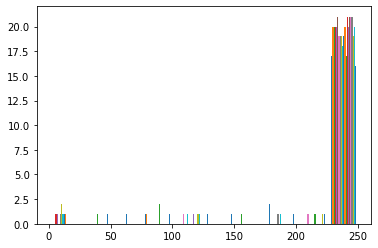

In [77]:
a = plt.hist(X)

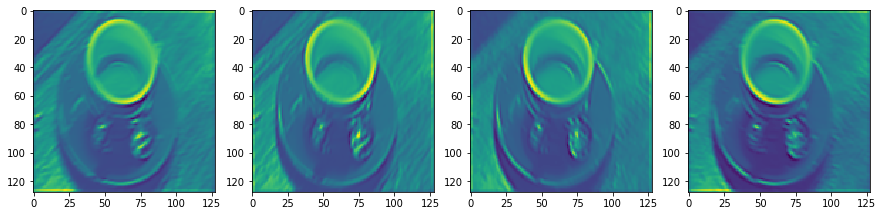

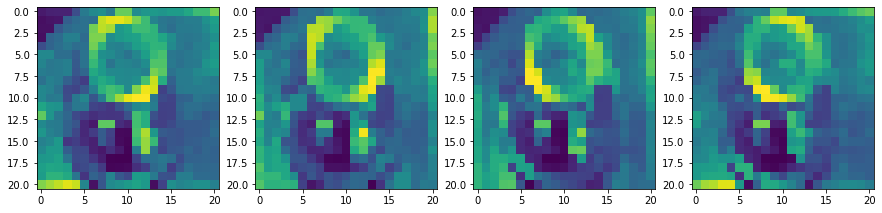

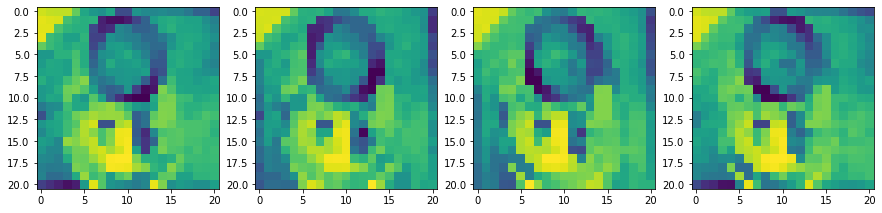

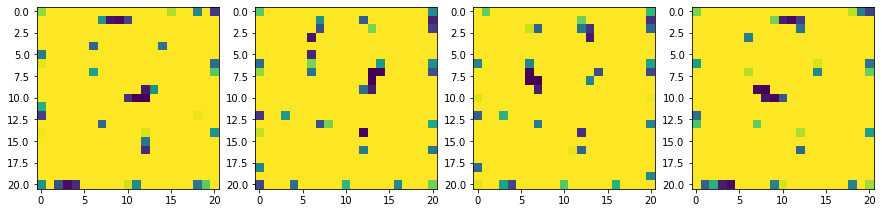

In [78]:
plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(S1maps['scale0'][i,:,:])
    
plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(C1maps['scale0'][i,:,:])
    
plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(C1maps_encoded['scale0'][i,:,:])

plt.figure(figsize=(15,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    X = C1maps_inh['scale0'][i,:,:]
    X = np.clip(X, 0.01, 251.0)
#     X = X/np.linalg.norm(X)
    plt.imshow(X, vmin=0.01, vmax=250.0)
# plt.colorbar()

Text(0.5, 1.0, 'If smaller scales have overall later firing, they will never win')

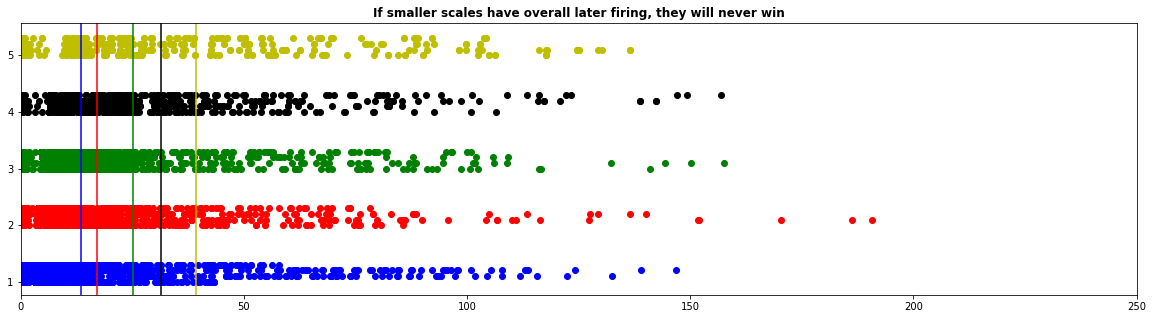

In [131]:
c = ['b', 'r', 'g', 'k', 'y']
M = {}
plt.figure(figsize=(20,5))
C = 0
for scale in C1maps_inh.keys():
    X = C1maps_inh[scale]
    for i in range(4):
        plt.scatter(X[i,:,:].flatten(), C+0.1*i + np.ones_like(X[i,:,:].flatten()), c=c[C])
    M[scale] = np.mean(X)
    C += 1
plt.xlim(0, 250)
for i, m in enumerate(M.values()):
#     print(i, m)
    plt.axvline(m, c=c[i])
    
plt.title('If smaller scales have overall later firing, they will never win', weight='bold')


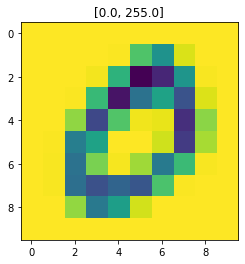

In [151]:
shp = (10,10)
im = mnist['data'][1].reshape(28,28)
plt.title([im.min(), im.max()])
im = 255 - imresize(im, shp)
plt.imshow(im)

In [ ]:
############################################################################################################

In [31]:
# plt.ioff()
# snapshot_num = 0
# for frame in range(nframes):
#     """ otherwise, load a precomputed C1maps_inh from a random image: """
#     C1maps_inh, fig_im = get_random_C1_inh(path)
#     while True:
#         C1maps_inh, fig_im = get_random_C1_inh(path)
#         if int(fig_im) in [0,1,2,3,4]:
#             break
#     S2, voltage = get_S2___(W=W, C1maps_inh=C1maps_inh, T=250.0, dt=0.01, neuron_type='iaf_psc_alpha', n=n)
#     W, DW = STDP___(W, S2, C1maps_inh)
    
#     if frame % snapshot_every == 0:
#         [snapshot(neuron_id, W, DW, frame, snapshot_num) for neuron_id in range(n)]
#         snapshot_num += 1
#         with open('weights', 'wb') as f:
#             pickle.dump(W, f)
#         plot_backprojection(W, G, n, frame, snapshot_num)
        
#     printProgressBar(frame, nframes-1, prefix = 'Progress:', suffix = 'Complete', length=50)

# saveNcleanup(n)

In [5]:
with open('weights', 'rb') as f:
    W = pickle.load(f)

<ipython-input-1-ac82a2bc70c4>:342: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Progress: |██████████████████████████████████████████████████| 100.0% win_n: 3 @ scale1


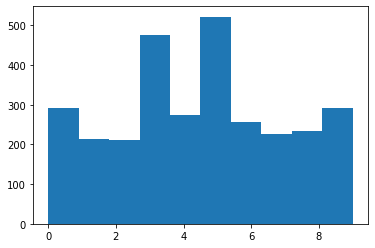

In [11]:
""" not on random, but on 100 C1inh maps """

plt.ioff()
snapshot_num = 0

WIN_NEUR = []
for frame in range(nframes):
    needed_target = int(np.random.choice(5))
    C1maps_inh, fig_im, pointer = get1of100(DS, needed_target, addr)
    S2, voltage, times = get_S2___(W=W, C1maps_inh=C1maps_inh, T=250.0, dt=0.01, neuron_type='iaf_psc_alpha', n=n)
    
    W, DW, win_neur, win_scale = STDP___(W, S2, C1maps_inh, n)
    
    if frame % snapshot_every == 0:
        [snapshot(neuron_id, W, DW, frame, snapshot_num) for neuron_id in range(n)]
        snapshot_num += 1
        with open('weights', 'wb') as f:
            pickle.dump(W, f)
        plot_backprojection(W, G, n, frame, snapshot_num)
    
    suffix = 'win_n: {} @ {}'.format(win_neur, win_scale)
    printProgressBar(frame, nframes-1, prefix = 'Progress:', suffix=suffix, length=50)
    WIN_NEUR.append(win_neur)

saveNcleanup(n)
a = plt.hist(WIN_NEUR)




In [15]:
n

10

In [17]:
for scale in W.keys():
    print('{}, {}'.format(scale, [np.linalg.norm(W[scale][N]) for N in range(n)]))

scale0, [0.9999999999999999, 1.0, 0.9999999999999999, 1.0]


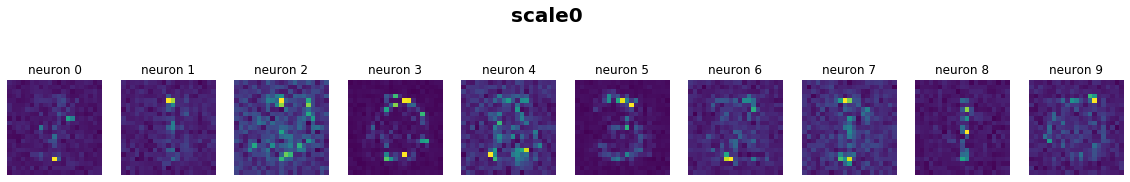

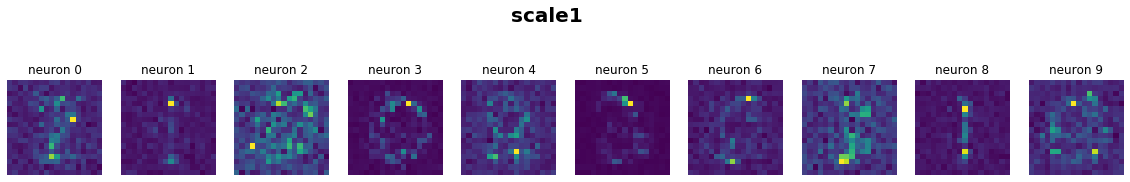

In [18]:
%matplotlib inline
""" WEIGHTS AVERAGED OVER ORIENTATIONS """

for scale in W.keys():
    plt.figure(figsize=(20,3.5))
    plt.suptitle(scale, weight='bold', fontsize=20)
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.title('neuron {}'.format(i))
        plt.imshow(np.mean(W[scale][i], axis=0))
        plt.gca().set_yticklabels([])
        plt.gca().set_xticklabels([])
        plt.gca().set_axis_off()
        

In [ ]:
# TEST

res = []
N = 100
for i in range(N):
    printProgressBar(i, N-1, prefix = 'Progress:', suffix=suffix, length=50)
    needed_target = int(np.random.choice(3))
    C1maps_inh, fig_im, pointer = get1of100(DS, needed_target, addr)
    S2, voltage, times = get_S2___(W=W, C1maps_inh=C1maps_inh, T=250.0, dt=0.01, neuron_type='iaf_psc_alpha', n=n)
    ws_t, winning_scale, winning_neuron = get_winning_scale___(S2)
    res.append((fig_im, winning_neuron))

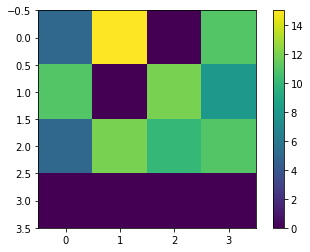

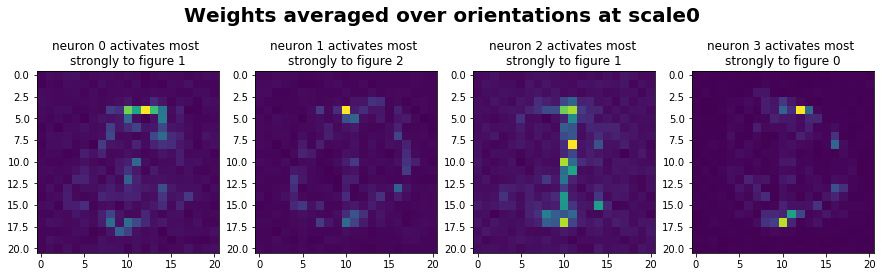

In [57]:
res
M = np.zeros((4,4))
for k in res:
    M[int(k[0]),k[1]] += 1

plt.figure()
plt.imshow(M)
plt.colorbar()
# max_ids = np.argmax(M, axis=1)
# print(max_ids)



# # find which input image elicits maximum response at which neuron:
# plt.figure()
# M = M/(1+M.sum(axis=1).reshape(-1,1)) # compute per-neuron probabilities of repsonses 
# max_ids = np.argmax(M, axis=1)
# print(max_ids)
# # plt.imshow(M)
# plt.imshow(M[:, max_ids])
# plt.ylabel('Ground truth', weight='bold')
# plt.colorbar()

for scale in W.keys():
    plt.figure(figsize=(15,4.5))
    plt.suptitle('Weights averaged over orientations at {}'.format(scale), weight='bold', fontsize=20)
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.title('neuron {} activates most \nstrongly to figure {}'.format(i, max_ids[i]))
        plt.imshow(np.mean(W[scale][i], axis=0))


    

In [33]:
max_ids = np.argmax(M, axis=1)
max_ids

array([1, 2, 2, 0])

In [286]:
# inspect weights (mean, negatives)
# train on only one figure
# one scale


1 1 (6, '1')


<ipython-input-66-0098297aca3a>:342: FutureWarning:Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/r/roman-koshkin/miniconda3/envs/NEST/lib/python3.8/site-packages/scipy/signal/waveforms.py:675: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0 0 (8, '0')


<ipython-input-83-9a77330961ad>:13: RuntimeWarning:invalid value encountered in double_scalars


Text(0.5, 1.0, 'nan')

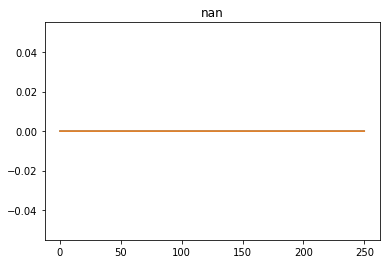

In [83]:
%matplotlib inline
# get filter coefficients:
tau_f_1 = 2e-3
tau_f_2 = 4e-3
fs_ = 1/dt*1000
fc = 1/(2*np.pi*np.sqrt(tau_f_1*tau_f_2))
B, A = butter(2, fc / (fs_ / 2), btype='low') # 2nd order Butterworth low-pass


def get_C(Sd, So, B, A):
    out1 = filtfilt(B, A, So)
    out2 = filtfilt(B, A, Sd)
    C = out1.dot(out2)/(np.linalg.norm(out1) * np.linalg.norm(out2))
    return C, out1, out2

N = 1

needed_target = int(1)
C1maps_inh, fig_im, pointer = get1of100(DS, needed_target, addr)
print(needed_target, fig_im, pointer)
S2_0, _, times = get_S2___(W=W, C1maps_inh=C1maps_inh, T=250.0, dt=0.01, neuron_type='iaf_psc_alpha', n=n)
S2_0 = signal.unit_impulse(len(times), np.searchsorted(times,S2_0[scale][N]))

needed_target = int(0)
C1maps_inh, fig_im, pointer = get1of100(DS, needed_target, addr)
print(needed_target, fig_im, pointer)
S2_1, _, times = get_S2___(W=W, C1maps_inh=C1maps_inh, T=250.0, dt=0.01, neuron_type='iaf_psc_alpha', n=n)
S2_1 = signal.unit_impulse(len(times), np.searchsorted(times,S2_1[scale][N]))


N = 0
# plt.plot(times, S2_0)
# plt.plot(times, S2_1)
C, out1, out2 = get_C(S2_0, S2_1, B, A)

plt.plot(times, out1)
plt.plot(times, out2)
plt.title(C)

In [8]:
%matplotlib inline
plot_backprojection(W, G, n, frame, snapshot_num)

In [3]:
with open('weights', 'rb') as f:
    W = pickle.load(f)

In [ ]:
for scale in W.keys():
    for N in range(2):
        print(np.linalg.norm(W[scale][N]))

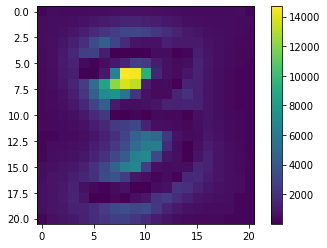

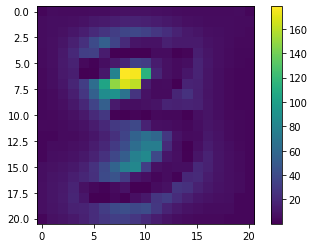

In [37]:
needed_target = int(np.random.choice(5))
C1maps_inh, fig_im, pointer = get1of100(DS, needed_target, addr)
    
%matplotlib inline
plt.figure()
plt.imshow(C1maps_inh['scale0'][0,:,:])
plt.colorbar()
plt.figure()
for scale in C1maps_inh.keys():
    C1maps_inh[scale] = C1maps_inh['scale0'] / np.linalg.norm(C1maps_inh['scale0']) * 1000
plt.imshow(C1maps_inh['scale0'][0,:,:])
plt.colorbar()

In [16]:
np.linalg.norm(C1maps_inh['scale0'])

83504.8111578794

In [52]:
np.min(C1maps_inh['scale4'])

0.01

# We keep the norm of the weights at 1.0 (HOMEOSTASIS)
# implement a second Hebbian layer
# lateral inhibition in real brain

In [474]:
from scipy.stats import entropy
N = 10
W = [np.random.rand(28,28) for i in range(N)]

In [475]:
for j in range(500000):
    samp = np.random.choice(70000)
    X = mnist['data'][samp].reshape(28,28)
    W = [W[i]/np.linalg.norm(W[i]) for i in range(N)]
    winner = np.argmax([np.sum(W[i]*X) for i in range(N)])
    X_ = X/np.linalg.norm(X)
    X_ = X_ + 1 - 0.5*(np.max(X_))                             # uncomment to add LTD
    X_ = X/np.linalg.norm(X)
    W[winner] += 0.1 * W[winner] * X_  #/np.linalg.norm(X))     # Hebbian learning
    W[winner] = np.clip(W[winner], a_min=0.0, a_max=0.1)
    W[winner] = W[winner]/np.linalg.norm(W[winner])
    if j % 2000 == 0:
        print(j)
        fig = plt.figure(figsize=(15,5))
        for i in range(10):
            plt.subplot(2,5,i+1)
            plt.imshow(W[i])
        plt.savefig('frame_{:05d}.png'.format(j), dpi=100, transparent=False, pad_inches=0.1, format='png')
        plt.close(fig)
with tarfile.open("snapshot.tar.gz", "w:gz") as tar:
    for name in [fn for fn in os.listdir() if fn.startswith('frame_')]:
        tar.add(name)
files = os.listdir()
for i in files:
    if 'frame_' in i:
        os.remove(i)


        
    


0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000
80000
82000
84000
86000
366000
368000
370000
372000
374000
376000
378000
380000
382000
384000
386000
388000
390000
392000
394000
396000
398000
400000
402000
404000
406000
408000
410000
412000
414000
416000
418000
420000
422000
424000
426000
428000
430000
432000
434000
436000
438000
440000
442000
444000
446000
448000
450000
452000
454000
456000
458000
460000
462000
464000
466000
468000
470000
472000
474000
476000
478000
480000
482000
484000
486000
488000
490000
492000
494000
496000
498000


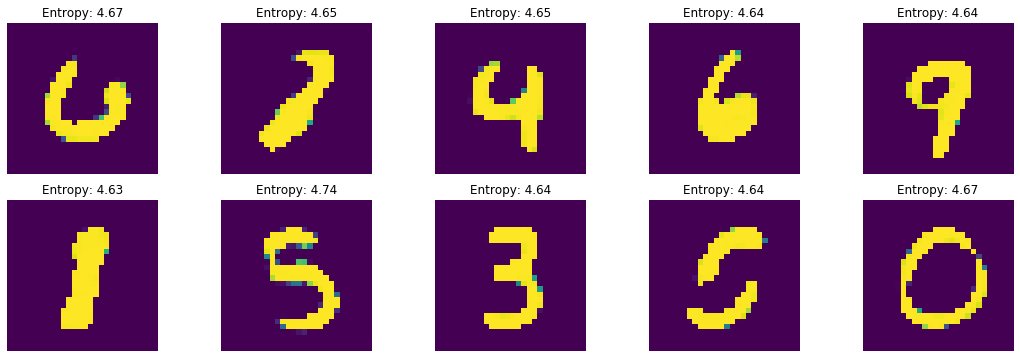

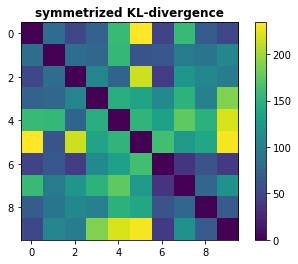

In [476]:
fig = plt.figure(figsize=(15,10))
for i in range(N):
    plt.subplot(4,5,i+1)
    plt.imshow(W[i])
    plt.title('Entropy: {:.2f}'.format(entropy((W[i]/W[i].sum()).flatten())))
    plt.gca().set_yticklabels([])
    plt.gca().set_xticklabels([])
    plt.gca().set_axis_off()
plt.tight_layout()

plt.figure()
E = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        p_i = (W[i]/np.sum(W[i])).flatten()
        p_j = (W[j]/np.sum(W[j])).flatten()
        E[i,j] = entropy(p_i, p_j) + entropy(p_j, p_i) # symmetrized KL-divergence (see Wiki)
plt.imshow(E)
plt.title('symmetrized KL-divergence', weight='bold')
plt.colorbar()

Text(0.5, 1.0, 'Winner weight matrix')

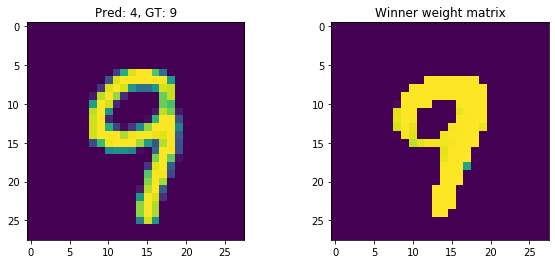

In [506]:
samp = np.random.choice(70000)
X = mnist['data'][samp].reshape(28,28)
prediction = np.argmax([np.sum(W[i]*X) for i in range(N)])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(X)
plt.title('Pred: {}, GT: {}'.format(prediction, mnist['target'][samp]))
plt.subplot(1,2,2)
plt.imshow(W[prediction])
plt.title('Winner weight matrix')

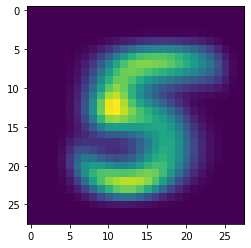

In [304]:
X = np.zeros((28,28))
idx = [j for j, i in enumerate(mnist['target']) if i=='5']
for i in idx:
    X += mnist['data'][i].reshape(28,28)
X = X/len(idx)
plt.imshow(X)

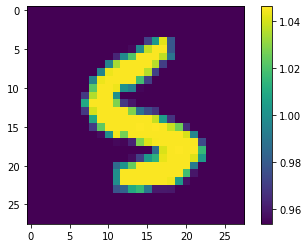

In [269]:
plt.imshow(X_)
plt.colorbar()